In [ ]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## A/B Testing

**Please run all cells before this cell, including the import cell at the top of the notebook.**

In [ ]:
baby = Table.read_table('baby.csv')
baby

In [ ]:
# What type of study is this?
#Let's just look at the two columns of interest

smoking_and_birthweight = baby.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

In [ ]:
# I am curious how many of these mothers smoked during pregnancy. 
smoking_and_birthweight.group('Maternal Smoker')

In [ ]:
# Let's kick off our analysis with a visualization.  
#What type of variable is "birth weight".  What visualization is best?

smoking_and_birthweight.hist("Birth Weight", group = 'Maternal Smoker')

In [ ]:
# Now let's get some numerical summaries.  

means_tbl = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_tbl

In [ ]:
# Since I am comparing two groups, I am interested in the difference
means = means_tbl.column(1)
observed_difference = means.item(0) - means.item(1)
observed_difference

When we are looking at the difference between the two groups, our null hypothesis is that there IS NO DIFFERENCE.  (Slides)

In [9]:
# Create a single-column table so that we can shuffle the data 
# using the table.sample method. 
weights = smoking_and_birthweight.select('Birth Weight')
weights

Birth Weight
120
113
128
108
136
138
132
120
143
140


In [12]:
# Shuffle (permutation test!) the data using t.sample
# Specify that with_replacement is false because we need to 
# ensure that all of the values show up in the new sample
weights.sample(with_replacement = False)

Birth Weight
122
150
129
75
73
116
150
118
109
136


In [15]:
#Store shuffled data in an array by using table.column
shuffled_weights = weights.sample(with_replacement = False).column(0)
shuffled_weights

array([103, 144, 128, ..., 124, 141, 127])

In [16]:
#Create new table with this array

original_and_shuffled = smoking_and_birthweight.with_column(
    "Shuffled Birth Weight", shuffled_weights)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Birth Weight
False,120,103
False,113,144
True,128,128
True,108,118
False,136,125
False,138,166
False,132,120
False,120,122
True,143,136
False,140,111


In [17]:
# Let's look at how our original sample compares with the sample from 
# our simulation
original_and_shuffled.group('Maternal Smoker', np.average)

Maternal Smoker,Birth Weight average,Shuffled Birth Weight average
False,123.085,118.565
True,113.819,120.861


In [18]:
#Let's also store the labels 
group_labels = baby.select('Maternal Smoker')
group_labels

Maternal Smoker
False
False
True
True
False
False
False
False
True
False


In [26]:
# array of shuffled weights
shuffled_weights = weights.sample(with_replacement = False).column(0)
# table with shuffled weights assigned to group labels
shuffled_tbl = group_labels.with_column('Shuffled Weight', shuffled_weights)
# array of means of the two groups
means = shuffled_tbl.group('Maternal Smoker', np.average).column(1)
# difference between means of the two groups
new_difference = means.item(0) - means.item(1)
new_difference

-0.37812514283102416

In [27]:
# Shall we ask python to do this multiple times for us?
differences = make_array()

for i in np.arange(5000):
    # array of shuffled weights
    shuffled_weights = weights.sample(with_replacement = False).column(0)
    # table with shuffled weights assigned to group labels
    shuffled_tbl = group_labels.with_column('Shuffled Weight', shuffled_weights)
    # array of means of the two groups
    means = shuffled_tbl.group('Maternal Smoker', np.average).column(1)
    # difference between means of the two groups
    new_difference = means.item(0) - means.item(1)
    differences = np.append(differences, new_difference)

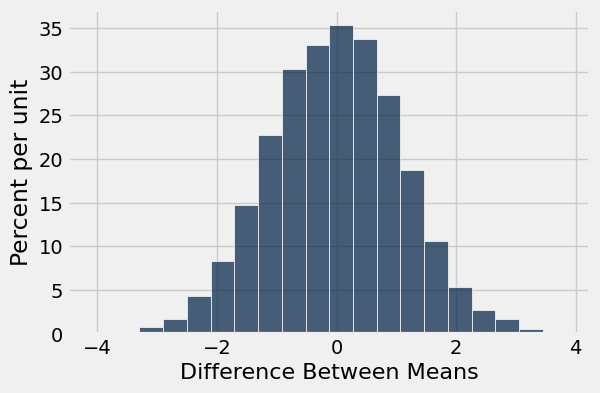

In [28]:
#What do our results look like?

Table().with_column('Difference Between Means', differences).hist(bins=20, ec='w')

In [29]:
# Now, where is our observed difference?
observed_difference

9.266142572024918

Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

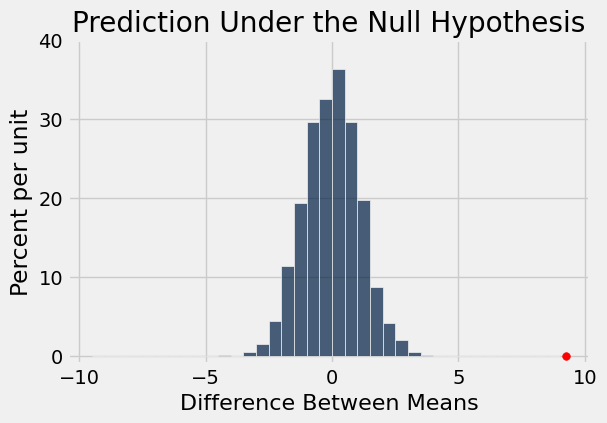

In [30]:
Table().with_column(
        'Difference Between Means', differences).hist(
        bins=np.arange((0-9.5), 9.5, 0.5)
)
plots.ylim(-0.01,0.4)
plots.scatter(observed_difference, 0, color='red', s=30, zorder=3)
plots.title('Prediction Under the Null Hypothesis')

In [31]:
#Shall we calculate an empirical p-value?

empirical_p = np.count_nonzero(differences >= observed_difference) /5000
empirical_p

0.0

## Deflategate

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

In [32]:
football = Table.read_table('deflategate.csv')
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


Notes: Each team starts with 12 balls.  Air pressure in the balls were measured at halftime by two officials.  The intercepted ball was not measured, and we can see that not all of the Colts balls were measured.  Unit of measurement is psi.

In [34]:
# Let's combine the two officials' meaurements with an average:
combined = (football.column(1) + football.column(2))/2
#and then create a table that just has 
football = football.select('Team').with_column('Combined', combined)
football.show()

ValueError: The index 2 is not in the table. Only indices between 0 and 1 are valid

In [35]:
#take a look:
football.show()

Team,Combined
Patriots,11.65
Patriots,11.025
Patriots,11.325
Patriots,10.85
Patriots,11.275
Patriots,11.775
Patriots,12.075
Patriots,11.325
Patriots,11.15
Patriots,10.7


At the start of the game, both teams started with pressures that were within what was allowed in the league, but they were different. Patriots: 12.5 psi, Colts: 13 psi.  Pressures do drop during the game, so we don't want to compare measured pressure, we want to compare the drop in pressure.

In [36]:
np.ones(5)

array([ 1.,  1.,  1.,  1.,  1.])

In [37]:
#Use np.ones to create an array of starting values.
start = np.append(12.5 * np.ones(11), 13* np.ones(4))
start

array([ 12.5,  12.5,  12.5,  12.5,  12.5,  12.5,  12.5,  12.5,  12.5,
        12.5,  12.5,  13. ,  13. ,  13. ,  13. ])

In [38]:
# Calculate the drop in pressure with array arithmetic.
drops = start - football.column('Combined')
drops

array([ 0.85 ,  1.475,  1.175,  1.65 ,  1.225,  0.725,  0.425,  1.175,
        1.35 ,  1.8  ,  1.375,  0.475,  0.475,  0.275,  0.65 ])

In [42]:
#Create a new table with the Team name and drops.

football = football.select('Team').with_column('Drop', drops)
football.show()

Team,Drop
Patriots,0.85
Patriots,1.475
Patriots,1.175
Patriots,1.65
Patriots,1.225
Patriots,0.725
Patriots,0.425
Patriots,1.175
Patriots,1.35
Patriots,1.8


In [43]:
#Let's look at summary statistic for each team
means_tbl = football.group('Team', np.average)
means_tbl

Team,Drop average
Colts,0.46875
Patriots,1.20227


In [44]:
#Compute a test statistic: "observed difference"
means = means_tbl.column(1)
observed_difference = means.item(0) - means.item(1)
observed_difference


-0.733522727272728

Could this difference be due to random chance alone? (Slides)

In [45]:
#Create a table of group labels and a table of drop values.
group_labels = football.select('Team')
drop_tbl = football.select('Drop')

In [54]:
# Shuffle the drops using t.sample
shuffled_drops = drop_tbl.sample(with_replacement = False).column(0)
#Create a new table of shuffled drops
shuffled_table = group_labels.with_column('Shuffled_Drop', shuffled_drops)
#Use t.group with average to compute new averages for each team
means = shuffled_table.group('Team', np.average).column(1)
#Compute the new difference
new_difference = means.item(0)-means.item(1)
new_difference



0.12727272727272665

In [55]:
# Ask Python to do this for us 10000 times!
differences = make_array()

for i in np.arange(10000):
    # Shuffle the drops using t.sample
    shuffled_drops = drop_tbl.sample(with_replacement = False).column(0)
    #Create a new table of shuffled drops
    shuffled_table = group_labels.with_column('Shuffled_Drop', shuffled_drops)
    #Use t.group with average to compute new averages for each team
    means = shuffled_table.group('Team', np.average).column(1)
    #Compute the new difference
    new_difference = means.item(0)-means.item(1)
    differences = np.append(differences, new_difference)
    


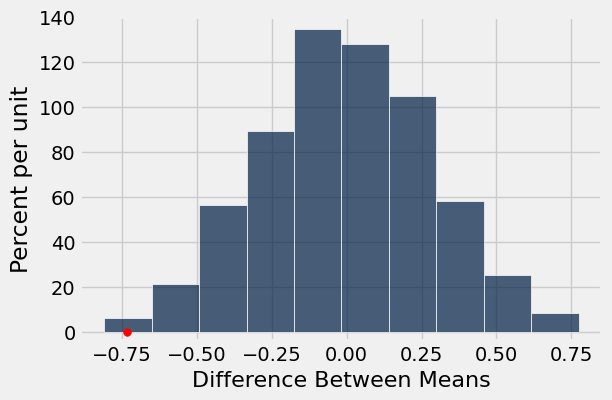

In [56]:
Table().with_column('Difference Between Means', differences).hist(ec='w')
plots.ylim(-0.04,1.4)
plots.scatter(observed_difference, 0, color='red', s=30, zorder=3);

In [57]:
#Shall we calculate an empirical p-value?

empirical_p = np.count_nonzero(differences <= observed_difference)/ 10000
empirical_p

0.0022